# Libraries

In [1]:
# System Libraries
import os
import glob
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import graphviz
from IPython.display import Image

# Metrics and Preprocessing
import cv2
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import sklearn.metrics as skmetrics
from sklearn.metrics import jaccard_score, f1_score

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose,
    concatenate, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Configurations

In [2]:
# Enable mixed precision training
# mixed_precision.set_global_policy('mixed_float16')

# Data setup
DATA_DIR = r'/kaggle/input/leukemia/Original'
MASK_DIR = r'/kaggle/input/leukemia/Segmented'
CLASSES = ['Benign', 'Early', 'Pre', 'Pro']

# Image dimensions
SIZE_X = 256
SIZE_Y = 256
CHANNELS = 3
IMG_SHAPE = (SIZE_X, SIZE_Y, CHANNELS)
N_CLASSES = 1

# Set batch size and other hyperparameters
N_FILTERS = 32
BATCH_SIZE = 32  
EPOCHS = 35  
LEARNING_RATE = 0.001
DROPOUT_RATE = 0
EXPERIMENT_NAME = "U-Net_Leukemia_Segmentation"

# Data Pre-Processing

In [3]:
# Load and preprocess all images and masks
images = []
masks = []

# Load and preprocess images
for class_name in CLASSES:
    class_dir = os.path.join(DATA_DIR, class_name)
    mask_class_dir = os.path.join(MASK_DIR, class_name)
    
    if not os.path.exists(class_dir) or not os.path.exists(mask_class_dir):
        continue
        
    for img_name in sorted(os.listdir(class_dir)):
        # Process image
        img_path = os.path.join(class_dir, img_name)
        mask_path = os.path.join(mask_class_dir, img_name)
        
        if not os.path.exists(mask_path):
            continue
            
        # Load and preprocess image
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE_Y, SIZE_X))
        img = img.astype(np.float32) / 255.0
        images.append(img)
        
        # Load and preprocess mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)
        mask = (mask > 128).astype(np.uint8)  # Binary threshold
        masks.append(mask)

images = np.array(images)
masks = np.array(masks)

In [4]:
# Ensure masks are binary
masks = (masks > 0).astype(np.float32)

# Add channel dimension
masks_input = np.expand_dims(masks, axis=-1)  # Shape: (num_samples, height, width, 1)

# Split dataset into train+val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images, masks_input, test_size=0.15, shuffle=True, random_state=42
)

# Calculate the proportion for validation set from the train+val data
val_size = 0.15 / (1 - 0.15)  # val_size = 0.15 / 0.85

# Split train+val into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=val_size, random_state=42
)

In [5]:
# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(1000).batch(BATCH_SIZE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)

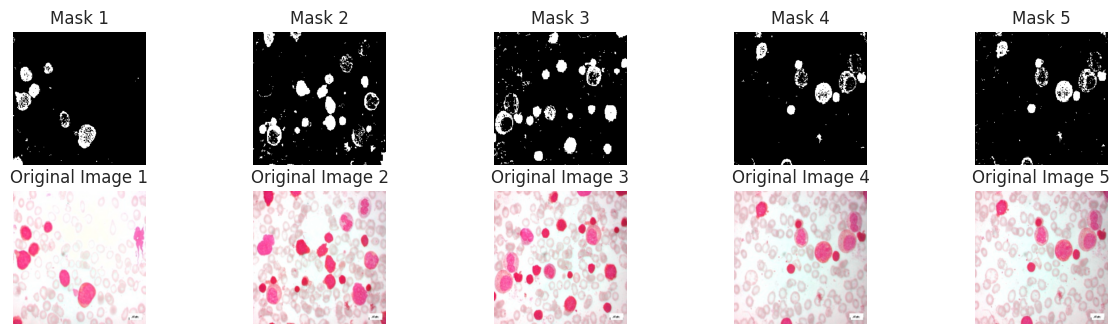

In [6]:
# Display sample images and their corresponding masks
plt.figure(figsize=(15, 10))

# Display images
for i in range(5):
    plt.subplot(5, 5, 1 + 5 + i)
    plt.axis('off')
    plt.imshow(images[i])
    plt.title(f'Original Image {i+1}')
              
# Display masks
for i in range(5):
    plt.subplot(5, 5, 1 + i)
    plt.axis('off')
    plt.imshow(masks[i], cmap='gray')
    plt.title(f'Mask {i+1}')
    
plt.show()

In [7]:
# Verify data information
print(f'IMAGES:\n'
      f'Unique values: {np.unique(images)}\n'
      f'Shape: {images.shape}\n'
      f'Type: {images.dtype}\n\n'
      f'MASKS:\n'
      f'Unique values: {np.unique(masks)}\n'
      f'Shape: {masks.shape}\n'
      f'Type: {masks.dtype}')

IMAGES:
Unique values: [0.         0.00392157 0.00784314 0.01176471 0.01568628 0.01960784
 0.02352941 0.02745098 0.03137255 0.03529412 0.03921569 0.04313726
 0.04705882 0.05098039 0.05490196 0.05882353 0.0627451  0.06666667
 0.07058824 0.07450981 0.07843138 0.08235294 0.08627451 0.09019608
 0.09411765 0.09803922 0.10196079 0.10588235 0.10980392 0.11372549
 0.11764706 0.12156863 0.1254902  0.12941177 0.13333334 0.13725491
 0.14117648 0.14509805 0.14901961 0.15294118 0.15686275 0.16078432
 0.16470589 0.16862746 0.17254902 0.1764706  0.18039216 0.18431373
 0.1882353  0.19215687 0.19607843 0.2        0.20392157 0.20784314
 0.21176471 0.21568628 0.21960784 0.22352941 0.22745098 0.23137255
 0.23529412 0.23921569 0.24313726 0.24705882 0.2509804  0.25490198
 0.25882354 0.2627451  0.26666668 0.27058825 0.27450982 0.2784314
 0.28235295 0.28627452 0.2901961  0.29411766 0.29803923 0.3019608
 0.30588236 0.30980393 0.3137255  0.31764707 0.32156864 0.3254902
 0.32941177 0.33333334 0.3372549  0.341176

In [8]:
# Print final dataset information
print(f'Final dataset shapes:')
print(f'TRAIN SET:\n'
      f'X_train shape: {X_train.shape}\n'
      f'y_train shape: {y_train.shape}\n\n'
      f'VALIDATION SET:\n'
      f'X_val shape: {X_val.shape}\n'
      f'y_val shape: {y_val.shape}\n\n'
      f'TEST SET:\n'
      f'X_test shape: {X_test.shape}\n'
      f'y_test shape: {y_test.shape}')

Final dataset shapes:
TRAIN SET:
X_train shape: (2278, 256, 256, 3)
y_train shape: (2278, 256, 256, 1)

VALIDATION SET:
X_val shape: (489, 256, 256, 3)
y_val shape: (489, 256, 256, 1)

TEST SET:
X_test shape: (489, 256, 256, 3)
y_test shape: (489, 256, 256, 1)


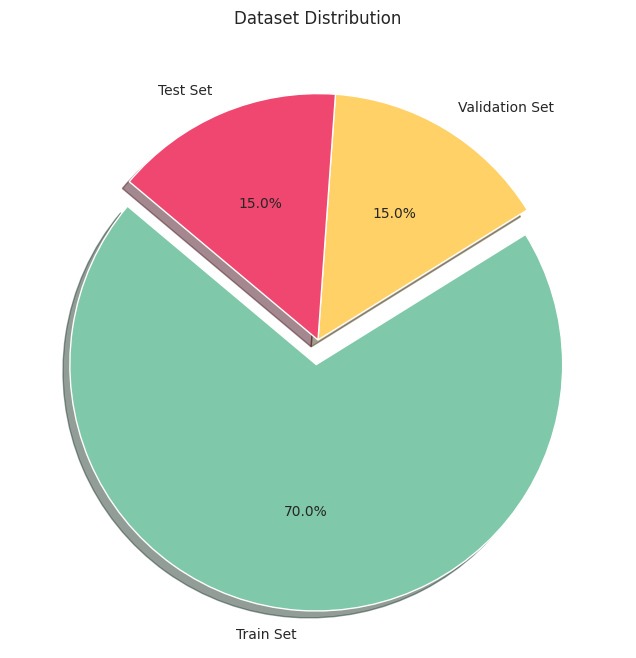

In [9]:
# Sizes of each dataset
sizes = [len(X_train), len(X_val), len(X_test)]
labels = ['Train Set', 'Validation Set', 'Test Set']
colors = ['#7FC8A9','#FFD166','#EF476F']
explode = (0.1, 0, 0)  # explode the 1st slice (Train Set)

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.title('Dataset Distribution')
plt.show()

# U-Net

In [10]:
# Convolutional Block (Double Convolution)
def double_conv_block(x, N_FILTERS):
    x = Conv2D(N_FILTERS, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    x = Conv2D(N_FILTERS, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    return x

# Downsample Block (Conv + MaxPooling)
def downsample_block(x, N_FILTERS):
    f = double_conv_block(x, N_FILTERS)
    p = MaxPooling2D(2)(f)
    return f, p

# Upsample Block (Transposed Conv + Concatenate + Double Convolution)
def upsample_block(x, conv_features, N_FILTERS):
    x = Conv2DTranspose(N_FILTERS, 3, 2, padding="same")(x)
    x = concatenate([x, conv_features])
    x = double_conv_block(x, N_FILTERS)
    return x

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  4,719,104 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 34,513,345 (131.66 MB)

 Trainable params: 34,513,345 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

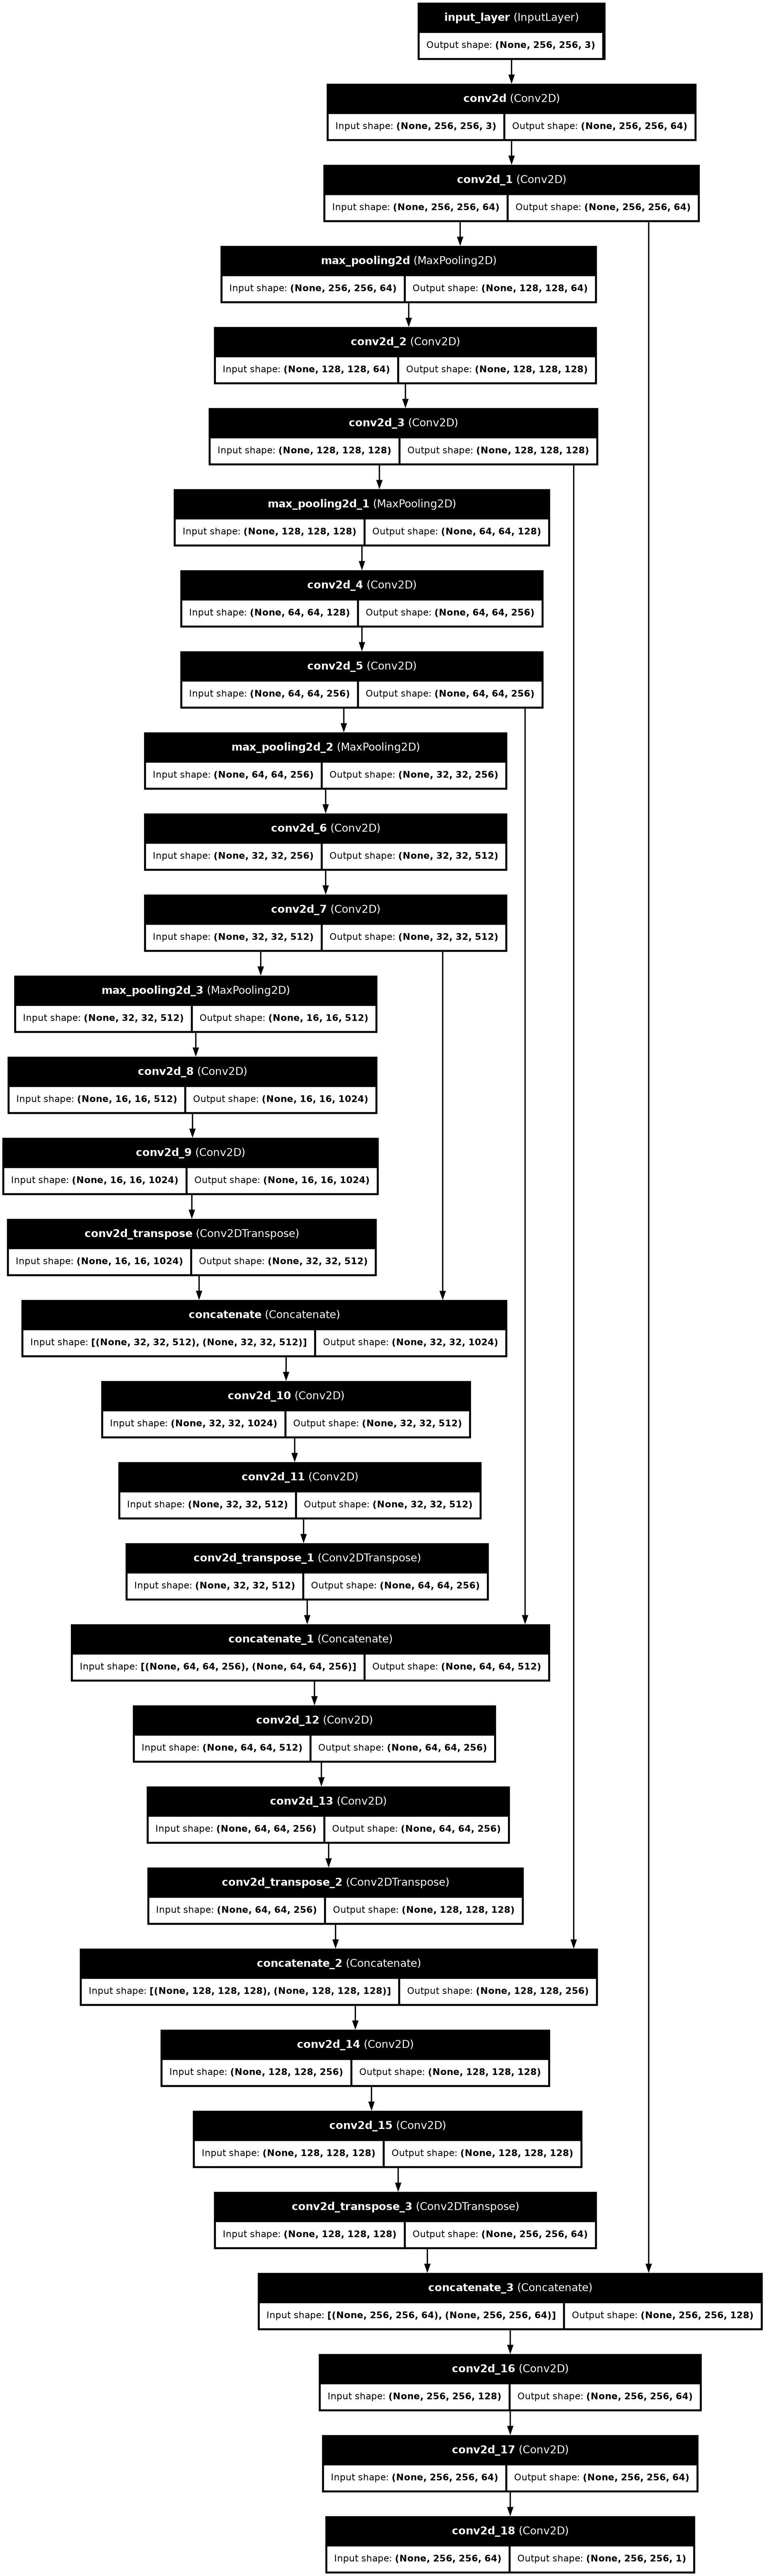

In [11]:
# U-Net Architecture using blocks
# Input layer
inputs = Input(IMG_SHAPE)

# Encoder (Contracting Path)
f1, p1 = downsample_block(inputs, 64)
f2, p2 = downsample_block(p1, 128)
f3, p3 = downsample_block(p2, 256)
f4, p4 = downsample_block(p3, 512)

# Bottleneck
bottleneck = double_conv_block(p4, 1024)

# Decoder (Expansive Path)
u6 = upsample_block(bottleneck, f4, 512)
u7 = upsample_block(u6, f3, 256)
u8 = upsample_block(u7, f2, 128)
u9 = upsample_block(u8, f1, 64)

# Output Layer
outputs = Conv2D(N_CLASSES, 1, padding="same", activation="sigmoid")(u9)

# Create Model
unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

# Model summary
unet_model.summary()

# Plot the Model
plot_model(unet_model, show_shapes = True, show_layer_names = True, dpi = 120)

In [12]:
# Cell 3 (Keep this - metrics are needed for model compilation)
# Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1.0):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Dice Loss
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

# IoU Metric
def iou_metric(y_true, y_pred, smooth=1.0):
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred), axis=[1, 2, 3])
    union = tf.keras.backend.sum(y_true, axis=[1, 2, 3]) + tf.keras.backend.sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = tf.keras.backend.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [13]:
# Cell 4 (Updated compilation with correct metric names)
optimizer = Adam(learning_rate=LEARNING_RATE)
metrics = [
    'accuracy',
    'Precision',
    'Recall',
    iou_metric,
    dice_coefficient
]

unet_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=metrics
)

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ModelCheckpoint(f'{EXPERIMENT_NAME}_best_model.keras', 
                   monitor='val_loss', 
                   save_best_only=True)
]

history = unet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/35


I0000 00:00:1733449298.646903      95 service.cc:145] XLA service 0x7da98400f820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733449298.646962      95 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1733449362.649935      95 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


72/72 ━━━━━━━━━━━━━━━━━━━━ 154s 1s/step - Precision: 0.5805 - Recall: 0.3941 - accuracy: 0.9276 - dice_coefficient: 0.3895 - iou_metric: 0.2246 - loss: 0.2236 - val_Precision: 0.8326 - val_Recall: 0.8305 - val_accuracy: 0.9712 - val_dice_coefficient: 0.7471 - val_iou_metric: 0.5031 - val_loss: 0.0710 - learning_rate: 0.0010
Epoch 2/35
72/72 ━━━━━━━━━━━━━━━━━━━━ 55s 769ms/step - Precision: 0.8270 - Recall: 0.8536 - accuracy: 0.9751 - dice_coefficient: 0.7649 - iou_metric: 0.4969 - loss: 0.0603 - val_Precision: 0.9288 - val_Recall: 0.8560 - val_accuracy: 0.9821 - val_dice_coefficient: 0.8205 - val_iou_metric: 0.5827 - val_loss: 0.0489 - learning_rate: 0.0010
Epoch 3/35
72/72 ━━━━━━━━━━━━━━━━━━━━ 55s 769ms/step - Precision: 0.9031 - Recall: 0.9011 - accuracy: 0.9843 - dice_coefficient: 0.8502 - iou_metric: 0.5883 - loss: 0.0415 - val_Precision: 0.9108 - val_Recall: 0.9234 - val_accuracy: 0.9857 - val_dice_coefficient: 0.8754 - val_iou_metric: 0.6387 - val_loss: 0.0370 - learning_rate: 0.0

# Results

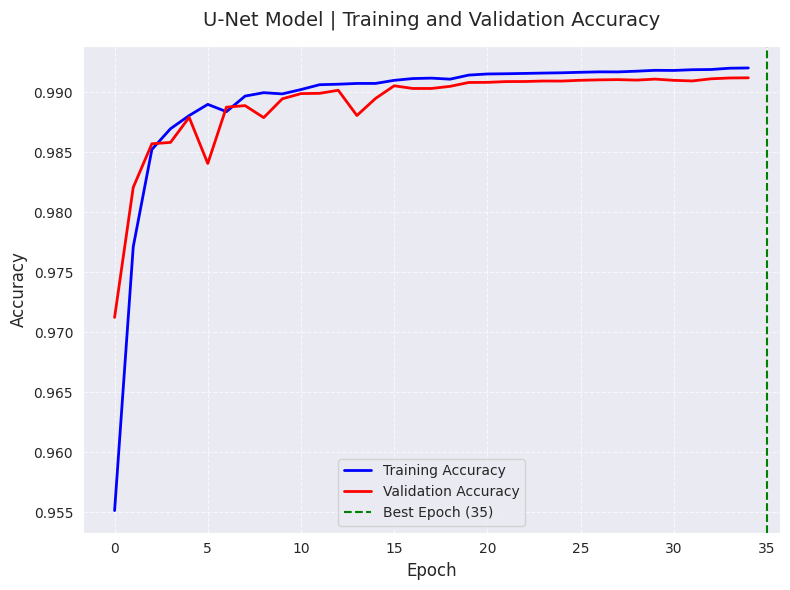

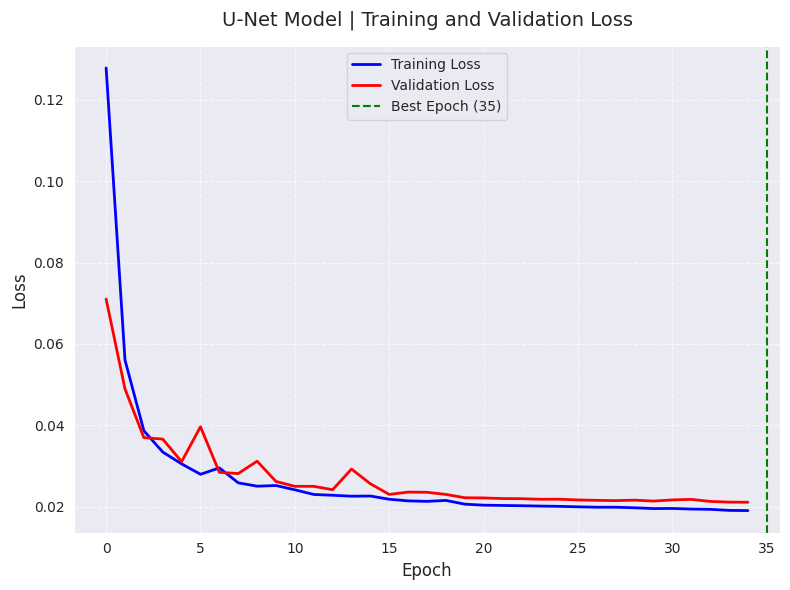

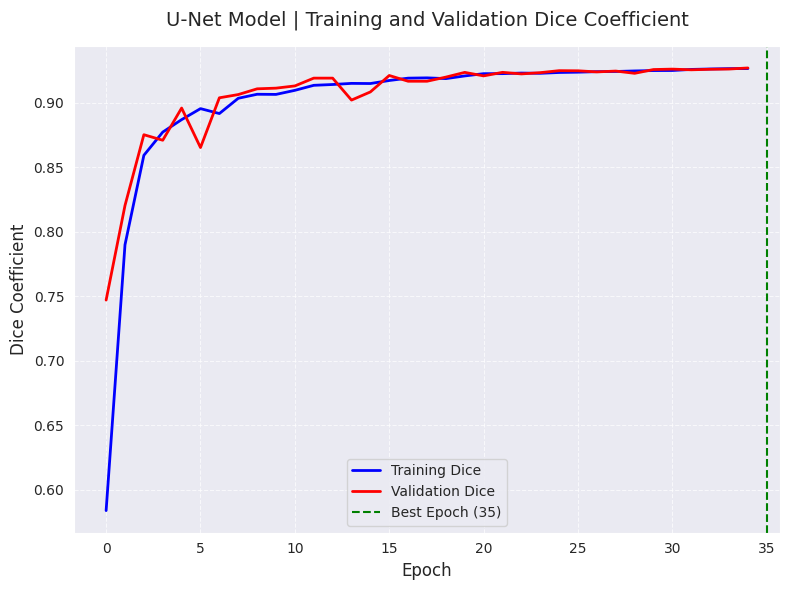

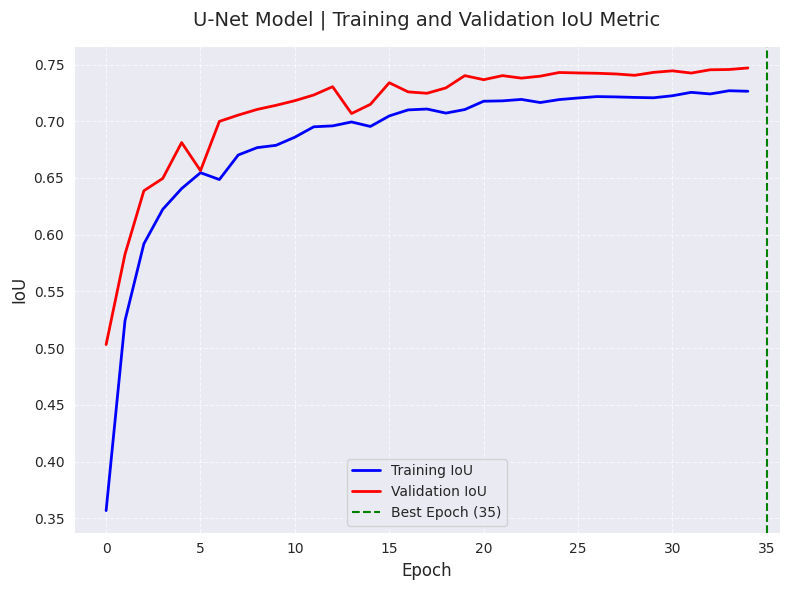


Best Epochs Summary:
--------------------------------------------------
Loss - Epoch:  35, Value: 0.0211
Dice - Epoch:  35, Value: 0.9272
IoU - Epoch:  35, Value: 0.7470
Accuracy - Epoch:  35, Value: 0.9912


In [14]:
# Get the best epochs for each metric
best_val_loss_epoch = np.argmin(history.history['val_loss']) + 1
best_val_dice_epoch = np.argmax(history.history['val_dice_coefficient']) + 1
best_val_iou_epoch = np.argmax(history.history['val_iou_metric']) + 1
best_val_acc_epoch = np.argmax(history.history['val_accuracy']) + 1

# Calculate the best metric values
min_val_loss = np.min(history.history['val_loss'])
max_val_dice = np.max(history.history['val_dice_coefficient'])
max_val_iou = np.max(history.history['val_iou_metric'])
max_val_acc = np.max(history.history['val_accuracy'])

# Plot Accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
plt.axvline(x=best_val_acc_epoch, color='g', linestyle='--', label=f'Best Epoch ({best_val_acc_epoch})')
plt.title('U-Net Model | Training and Validation Accuracy', fontsize=14, pad=15)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot Loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], 'b-', label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
plt.axvline(x=best_val_loss_epoch, color='g', linestyle='--', label=f'Best Epoch ({best_val_loss_epoch})')
plt.title('U-Net Model | Training and Validation Loss', fontsize=14, pad=15)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot Dice Coefficient
plt.figure(figsize=(8, 6))
plt.plot(history.history['dice_coefficient'], 'b-', label='Training Dice', linewidth=2)
plt.plot(history.history['val_dice_coefficient'], 'r-', label='Validation Dice', linewidth=2)
plt.axvline(x=best_val_dice_epoch, color='g', linestyle='--', label=f'Best Epoch ({best_val_dice_epoch})')
plt.title('U-Net Model | Training and Validation Dice Coefficient', fontsize=14, pad=15)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Dice Coefficient', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Plot IoU
plt.figure(figsize=(8, 6))
plt.plot(history.history['iou_metric'], 'b-', label='Training IoU', linewidth=2)
plt.plot(history.history['val_iou_metric'], 'r-', label='Validation IoU', linewidth=2)
plt.axvline(x=best_val_iou_epoch, color='g', linestyle='--', label=f'Best Epoch ({best_val_iou_epoch})')
plt.title('U-Net Model | Training and Validation IoU Metric', fontsize=14, pad=15)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('IoU', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print summary of best epochs and values
print("\nBest Epochs Summary:")
print("-" * 50)
print(f"Loss - Epoch: {best_val_loss_epoch:3d}, Value: {min_val_loss:.4f}")
print(f"Dice - Epoch: {best_val_dice_epoch:3d}, Value: {max_val_dice:.4f}")
print(f"IoU - Epoch: {best_val_iou_epoch:3d}, Value: {max_val_iou:.4f}")
print(f"Accuracy - Epoch: {best_val_acc_epoch:3d}, Value: {max_val_acc:.4f}")


Metrics Comparison Across Datasets:
-----------------------------------------------------------------
Metric          Training        Validation      Test           
-----------------------------------------------------------------
Loss                     0.0190          0.0211          0.0197
Accuracy                 0.9920          0.9912          0.9917
Precision                0.9463          0.9449          0.9413
Recall                   0.9539          0.9528          0.9488
IoU                      0.7264          0.7520          0.7215
Dice                     0.9261          0.9257          0.9198
-----------------------------------------------------------------


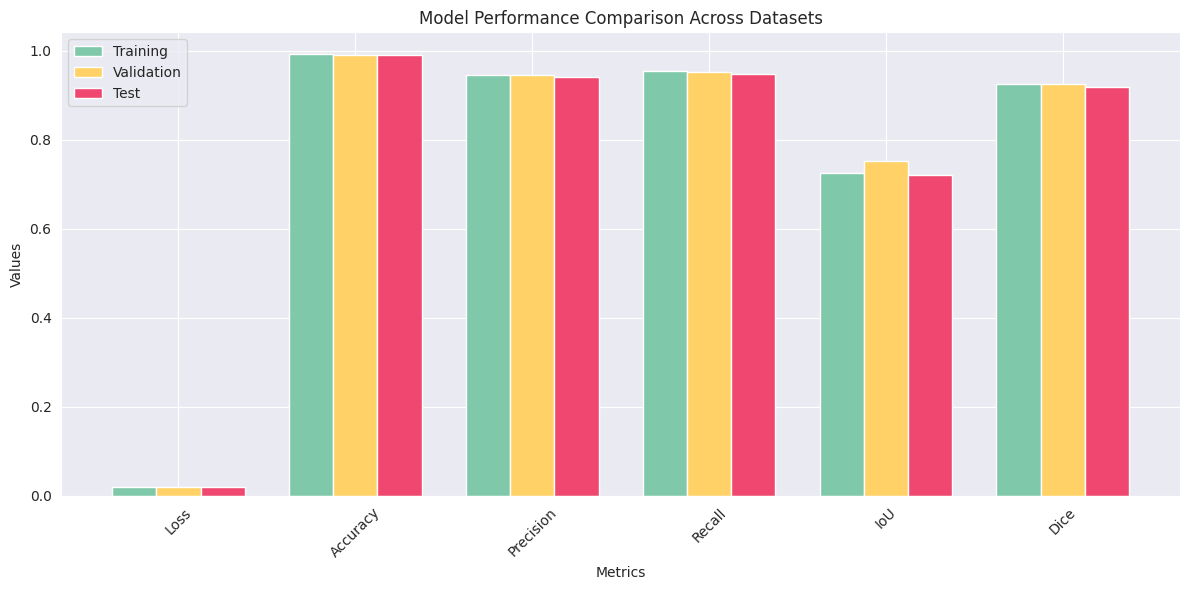

In [15]:
def evaluate_model(model, X, y, batch_size=10):
    return model.evaluate(X, y, batch_size=batch_size, verbose=0)

# Store results for comparison
results_dict = {}
# Get evaluation results without printing
results_dict['train'] = evaluate_model(unet_model, X_train, y_train, batch_size=10)
results_dict['val'] = evaluate_model(unet_model, X_val, y_val, batch_size=10)
results_dict['test'] = evaluate_model(unet_model, X_test, y_test, batch_size=10)

# Create comparison table
metrics_names = ['Loss', 'Accuracy', 'Precision', 'Recall', 'IoU', 'Dice']
print("\nMetrics Comparison Across Datasets:")
print("-" * 65)
print(f"{'Metric':15} {'Training':15} {'Validation':15} {'Test':15}")
print("-" * 65)
for i, metric in enumerate(metrics_names):
    train_val = results_dict['train'][i]
    val_val = results_dict['val'][i]
    test_val = results_dict['test'][i]
    print(f"{metric:15} {train_val:15.4f} {val_val:15.4f} {test_val:15.4f}")
print("-" * 65)

# Visualize metrics comparison
plt.figure(figsize=(12, 6))
x = np.arange(len(metrics_names))
width = 0.25

plt.bar(x - width, results_dict['train'], width, label='Training', color='#7FC8A9')
plt.bar(x, results_dict['val'], width, label='Validation', color='#FFD166')
plt.bar(x + width, results_dict['test'], width, label='Test', color='#EF476F')

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Model Performance Comparison Across Datasets')
plt.xticks(x, metrics_names, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

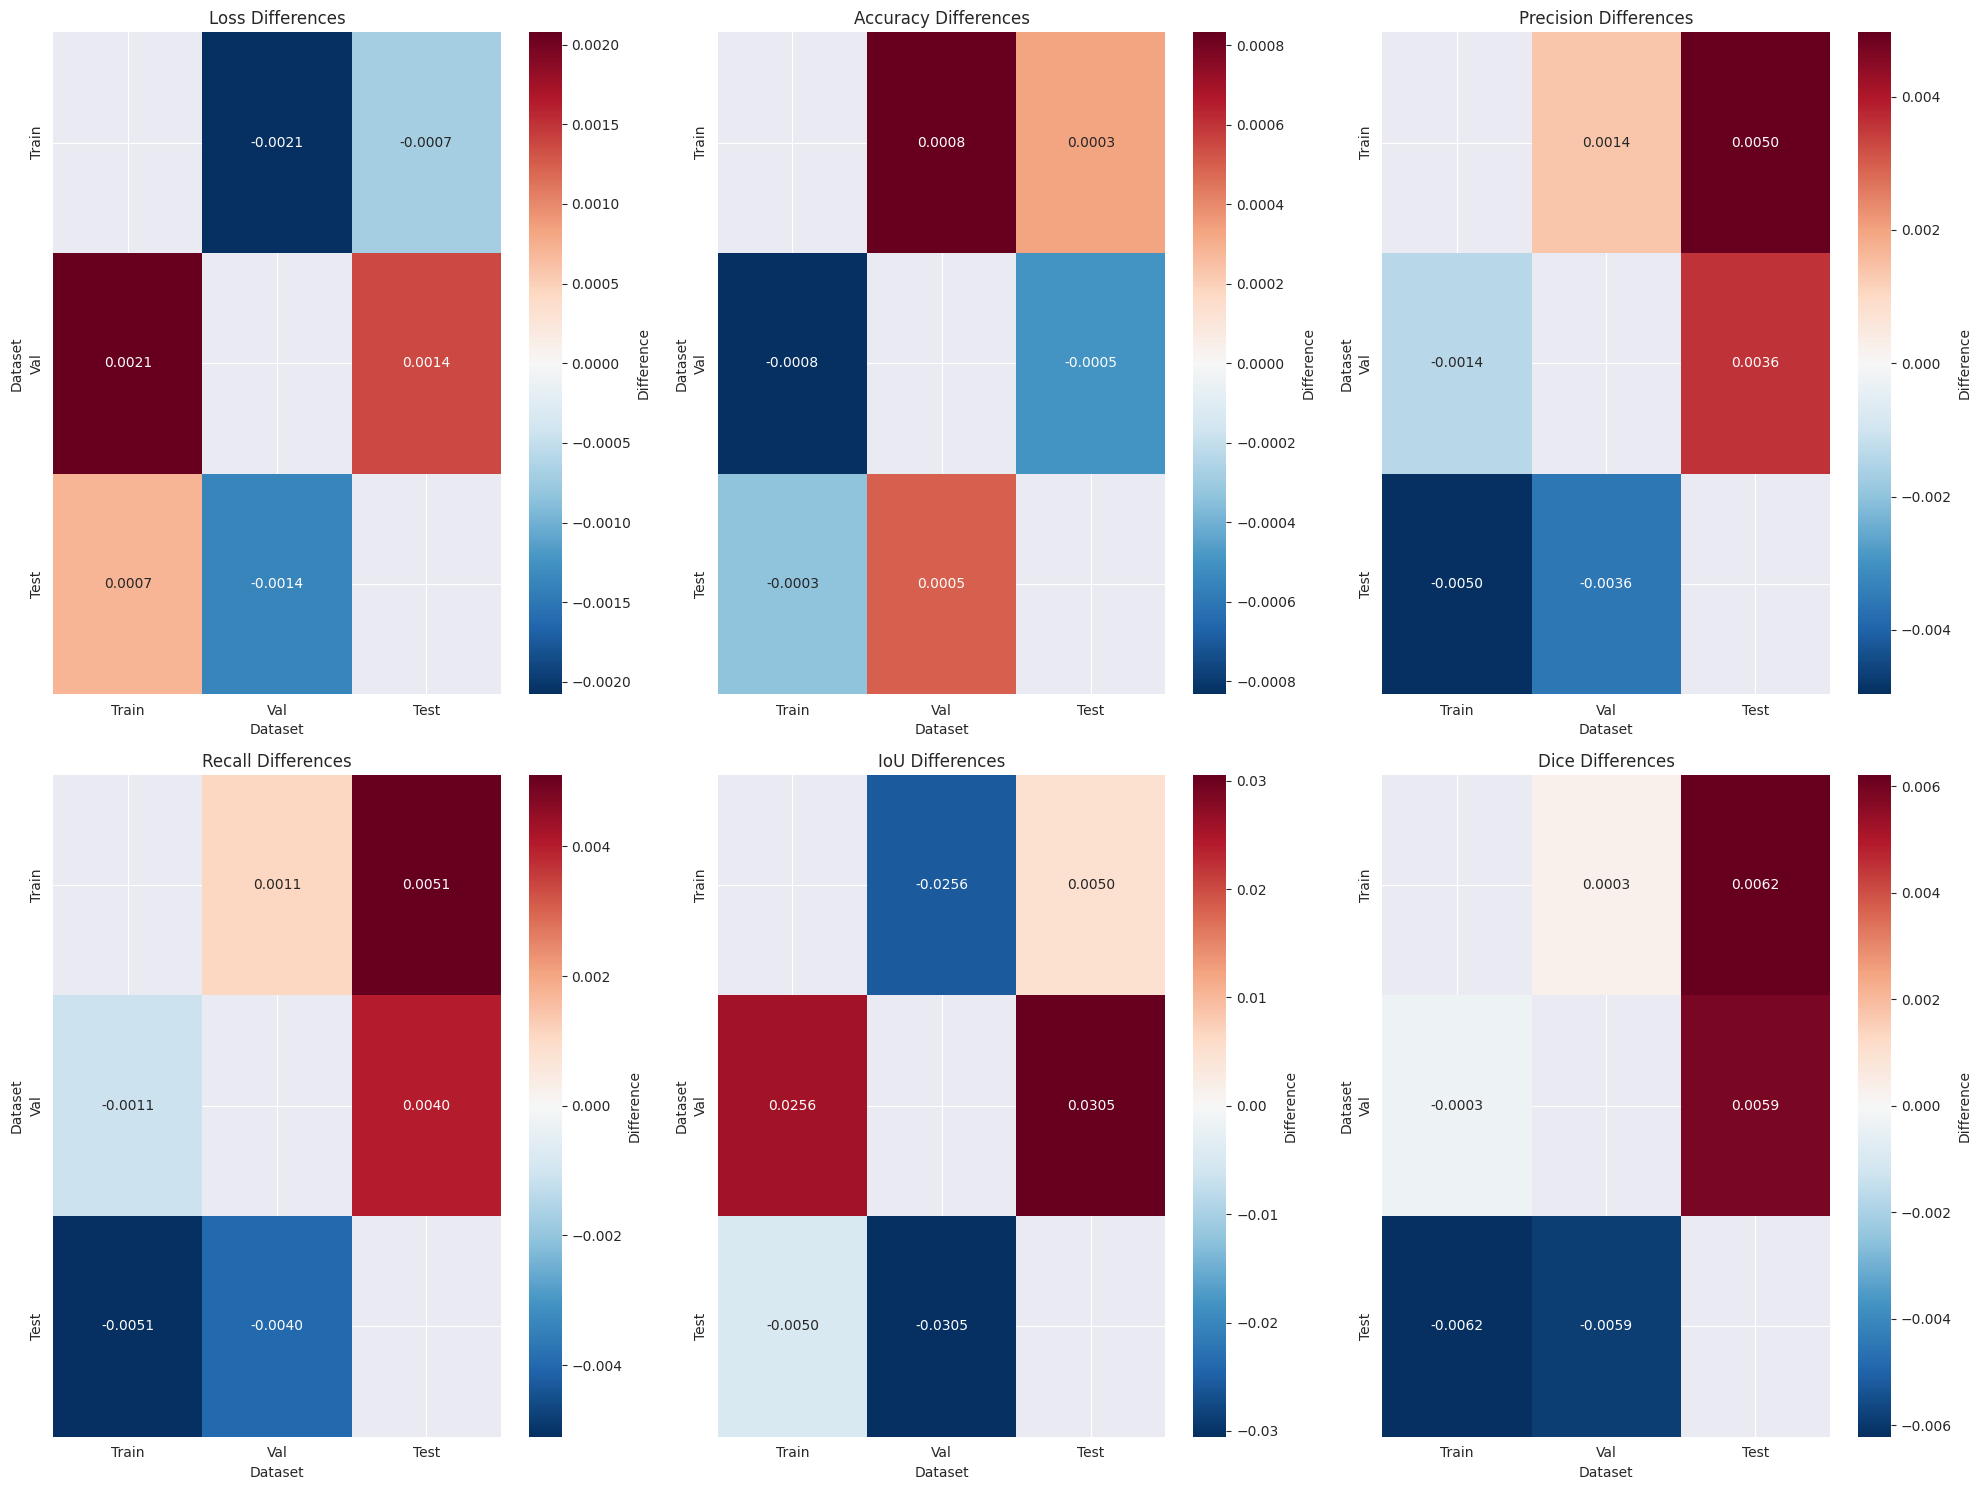


Detailed Metrics Differences Analysis:
----------------------------------------------------------------------

Loss Differences:
----------------------------------------
Train vs Val: -0.0021
Train vs Test: -0.0007
Val vs Test: +0.0014

Accuracy Differences:
----------------------------------------
Train vs Val: +0.0008
Train vs Test: +0.0003
Val vs Test: -0.0005

Precision Differences:
----------------------------------------
Train vs Val: +0.0014
Train vs Test: +0.0050
Val vs Test: +0.0036

Recall Differences:
----------------------------------------
Train vs Val: +0.0011
Train vs Test: +0.0051
Val vs Test: +0.0040

IoU Differences:
----------------------------------------
Train vs Val: -0.0256
Train vs Test: +0.0050
Val vs Test: +0.0305

Dice Differences:
----------------------------------------
Train vs Val: +0.0003
Train vs Test: +0.0062
Val vs Test: +0.0059


In [16]:
# Calculate differences between datasets
def calculate_differences():
    datasets = ['Train', 'Val', 'Test']
    diff_matrix = np.zeros((len(metrics_names), len(datasets), len(datasets)))
    
    for i, metric in enumerate(metrics_names):
        for j, d1 in enumerate(datasets):
            for k, d2 in enumerate(datasets):
                if j != k:  # Skip comparing dataset with itself
                    d1_lower = d1.lower()
                    d2_lower = d2.lower()
                    diff = results_dict[d1_lower][i] - results_dict[d2_lower][i]
                    diff_matrix[i, j, k] = diff
    
    return diff_matrix

# Create heatmap for each metric
diff_matrix = calculate_differences()
datasets = ['Train', 'Val', 'Test']

# Create a figure with subplots for each metric
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
axes = axes.ravel()

# Create heatmaps
for i, metric in enumerate(metrics_names):
    ax = axes[i]
    
    # Create heatmap data for this metric
    heatmap_data = diff_matrix[i]
    
    # Create mask for diagonal (self-comparison)
    mask = np.eye(len(datasets), dtype=bool)
    
    # Plot heatmap
    sns.heatmap(heatmap_data, 
                annot=True, 
                fmt='.4f', 
                cmap='RdBu_r',
                center=0,
                mask=mask,
                xticklabels=datasets,
                yticklabels=datasets,
                ax=ax,
                cbar_kws={'label': 'Difference'})
    
    ax.set_title(f'{metric} Differences')
    ax.set_xlabel('Dataset')
    ax.set_ylabel('Dataset')

plt.tight_layout()
plt.show()

# Print detailed analysis
print("\nDetailed Metrics Differences Analysis:")
print("-" * 70)
for i, metric in enumerate(metrics_names):
    print(f"\n{metric} Differences:")
    print("-" * 40)
    for j, d1 in enumerate(datasets):
        for k, d2 in enumerate(datasets):
            if j < k:  # Only print each comparison once
                diff = diff_matrix[i, j, k]
                print(f"{d1} vs {d2}: {diff:+.4f}")
                if abs(diff) > 0.1:  # Flag significant differences
                    print(f"   ⚠️ Large difference detected!")
                    if diff > 0:
                        print(f"   • {d1} performs better than {d2}")
                    else:
                        print(f"   • {d2} performs better than {d1}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


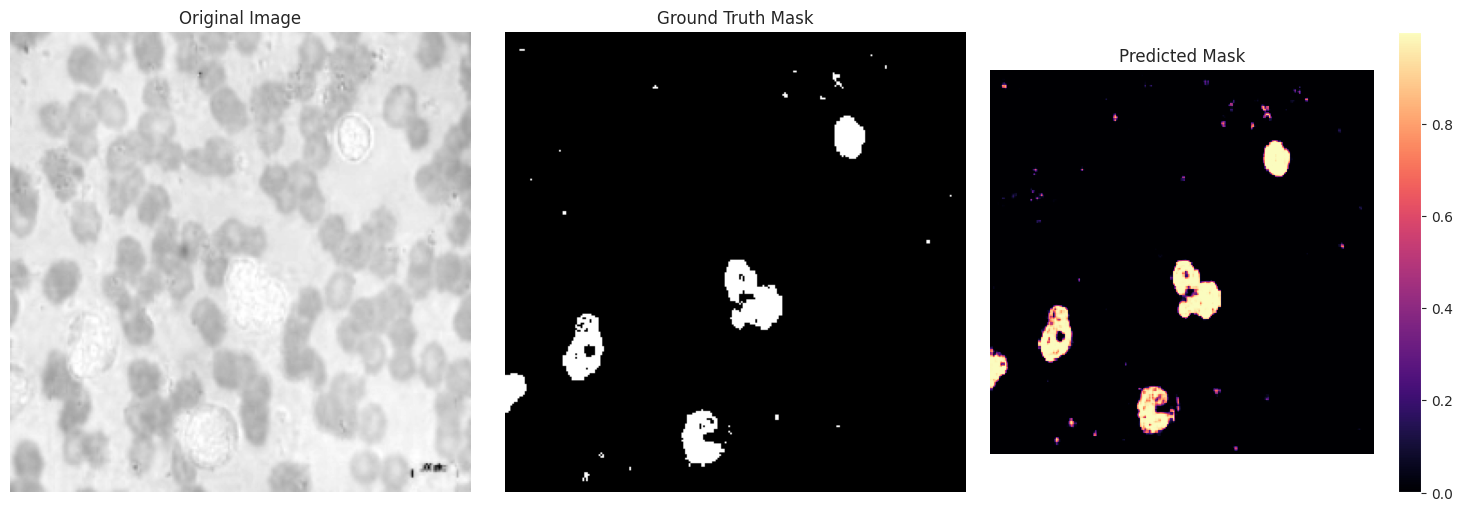

Dice coefficient for this prediction: 0.9142
IoU for this prediction: 0.8419


In [17]:
def visualize_prediction(model, X_test, y_test, idx=None):
    if idx is None:
        idx = np.random.randint(0, len(X_test))
    
    test_img = X_test[idx]
    test_mask = y_test[idx]
    
    # Make prediction
    test_pred = model.predict(test_img[np.newaxis, ...])
    test_pred_binary = (test_pred > 0.5).astype(np.uint8)
    
    # Create figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    ax1.imshow(test_img[..., 0], cmap='gray')
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    # Ground truth mask
    ax2.imshow(test_mask[..., 0], cmap='gray')
    ax2.set_title('Ground Truth Mask')
    ax2.axis('off')
    
    # Predicted mask
    pred_display = ax3.imshow(test_pred[0, ..., 0], cmap='magma')
    ax3.set_title('Predicted Mask')
    ax3.axis('off')
    
    # Add colorbar
    plt.colorbar(pred_display, ax=ax3)
    
    plt.tight_layout()
    plt.show()
    
    # Convert masks to float32 for metric calculation
    test_mask_float = tf.cast(test_mask, tf.float32)
    test_pred_float = tf.cast(test_pred, tf.float32)
    
    # Calculate metrics for this prediction
    dice = dice_coefficient(
        test_mask_float[np.newaxis, ...], 
        test_pred_float
    ).numpy()
    
    iou = iou_metric(
        test_mask_float[np.newaxis, ...], 
        test_pred_float
    ).numpy()
    
    print(f"Dice coefficient for this prediction: {dice:.4f}")
    print(f"IoU for this prediction: {iou:.4f}")

# Update the metric functions to ensure type consistency
def dice_coefficient(y_true, y_pred, smooth=1.0):
    # Ensure inputs are float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou_metric(y_true, y_pred, smooth=1.0):
    # Ensure inputs are float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred), axis=[1, 2, 3])
    union = tf.keras.backend.sum(y_true, axis=[1, 2, 3]) + tf.keras.backend.sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = tf.keras.backend.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

# Visualize a random prediction
visualize_prediction(unet_model, X_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


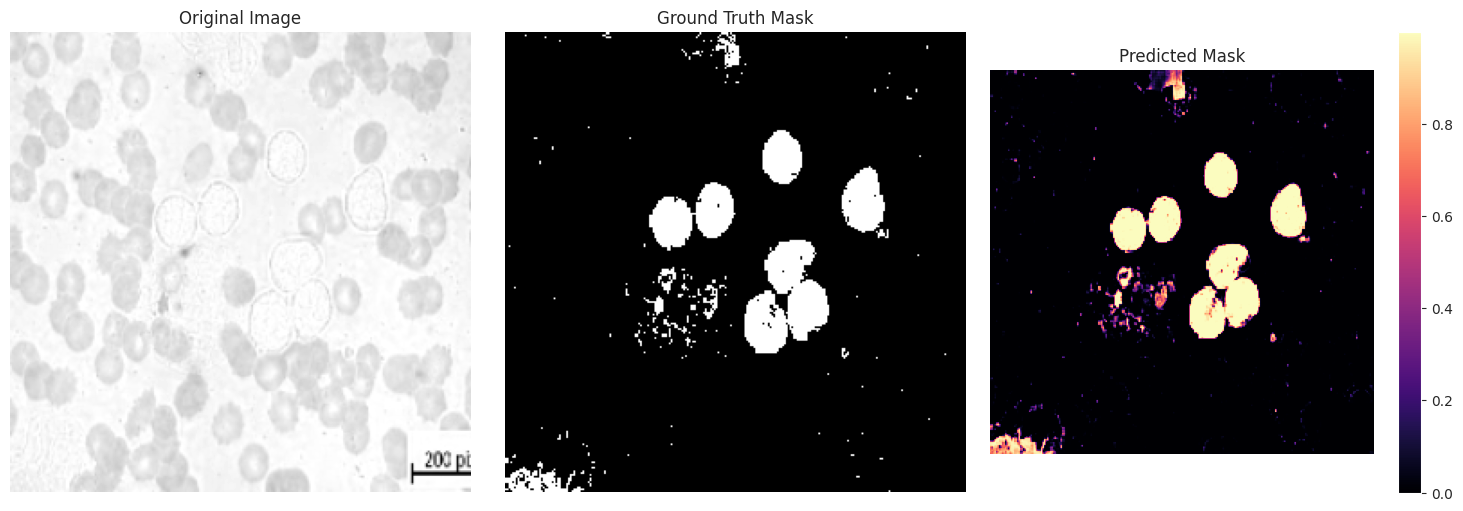

Dice coefficient for this prediction: 0.9140
IoU for this prediction: 0.8417


In [18]:
def visualize_prediction(model, X_test, y_test, idx=None):
    if idx is None:
        idx = np.random.randint(0, len(X_test))
    
    test_img = X_test[idx]
    test_mask = y_test[idx]
    
    # Make prediction
    test_pred = model.predict(test_img[np.newaxis, ...])
    test_pred_binary = (test_pred > 0.5).astype(np.uint8)
    
    # Create figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    ax1.imshow(test_img[..., 0], cmap='gray')
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    # Ground truth mask
    ax2.imshow(test_mask[..., 0], cmap='gray')
    ax2.set_title('Ground Truth Mask')
    ax2.axis('off')
    
    # Predicted mask
    pred_display = ax3.imshow(test_pred[0, ..., 0], cmap='magma')
    ax3.set_title('Predicted Mask')
    ax3.axis('off')
    
    # Add colorbar
    plt.colorbar(pred_display, ax=ax3)
    
    plt.tight_layout()
    plt.show()
    
    # Convert masks to float32 for metric calculation
    test_mask_float = tf.cast(test_mask, tf.float32)
    test_pred_float = tf.cast(test_pred, tf.float32)
    
    # Calculate metrics for this prediction
    dice = dice_coefficient(
        test_mask_float[np.newaxis, ...], 
        test_pred_float
    ).numpy()
    
    iou = iou_metric(
        test_mask_float[np.newaxis, ...], 
        test_pred_float
    ).numpy()
    
    print(f"Dice coefficient for this prediction: {dice:.4f}")
    print(f"IoU for this prediction: {iou:.4f}")

# Update the metric functions to ensure type consistency
def dice_coefficient(y_true, y_pred, smooth=1.0):
    # Ensure inputs are float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou_metric(y_true, y_pred, smooth=1.0):
    # Ensure inputs are float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred), axis=[1, 2, 3])
    union = tf.keras.backend.sum(y_true, axis=[1, 2, 3]) + tf.keras.backend.sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = tf.keras.backend.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

# Visualize a random prediction
visualize_prediction(unet_model, X_test, y_test)

# Save Model

In [19]:
unet_model.save('UNet_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


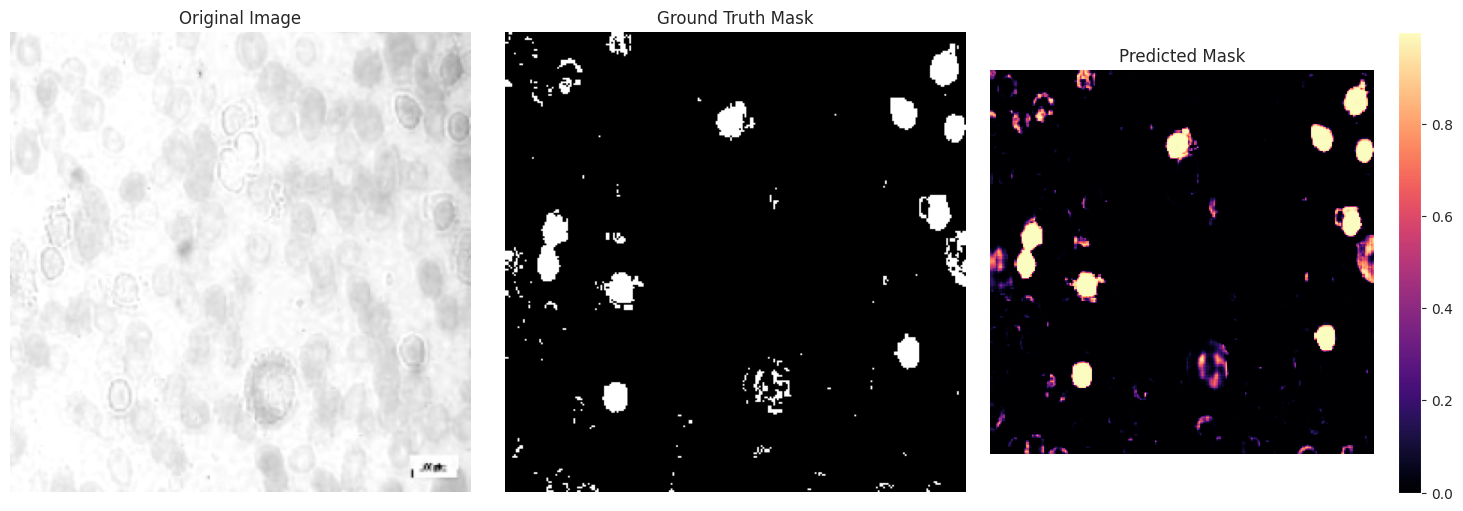

Dice coefficient for this prediction: 0.8127
IoU for this prediction: 0.6846


In [20]:
def visualize_prediction(model, X_test, y_test, idx):
    if idx is None:
        raise ValueError("Index of the sample image must be provided.")
    
    test_img = X_test[idx]
    test_mask = y_test[idx]
    
    # Make prediction
    test_pred = model.predict(test_img[np.newaxis, ...])
    test_pred_binary = (test_pred > 0.5).astype(np.uint8)
    
    # Create figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    ax1.imshow(test_img[..., 0], cmap='gray')
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    # Ground truth mask
    ax2.imshow(test_mask[..., 0], cmap='gray')
    ax2.set_title('Ground Truth Mask')
    ax2.axis('off')
    
    # Predicted mask
    pred_display = ax3.imshow(test_pred[0, ..., 0], cmap='magma')
    ax3.set_title('Predicted Mask')
    ax3.axis('off')
    
    # Add colorbar
    plt.colorbar(pred_display, ax=ax3)
    
    plt.tight_layout()
    plt.show()
    
    # Convert masks to float32 for metric calculation
    test_mask_float = tf.cast(test_mask, tf.float32)
    test_pred_float = tf.cast(test_pred, tf.float32)
    
    # Calculate metrics for this prediction
    dice = dice_coefficient(
        test_mask_float[np.newaxis, ...], 
        test_pred_float
    ).numpy()
    
    iou = iou_metric(
        test_mask_float[np.newaxis, ...], 
        test_pred_float
    ).numpy()
    
    print(f"Dice coefficient for this prediction: {dice:.4f}")
    print(f"IoU for this prediction: {iou:.4f}")

# Update the metric functions to ensure type consistency
def dice_coefficient(y_true, y_pred, smooth=1.0):
    # Ensure inputs are float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def iou_metric(y_true, y_pred, smooth=1.0):
    # Ensure inputs are float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.keras.backend.sum(tf.keras.backend.abs(y_true * y_pred), axis=[1, 2, 3])
    union = tf.keras.backend.sum(y_true, axis=[1, 2, 3]) + tf.keras.backend.sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = tf.keras.backend.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

# Visualize a specific prediction
visualize_prediction(unet_model, X_test, y_test, idx=80)